# Подготовка данных

## Загрузка датасетов

In [1]:
from pathlib import Path
from vk_mod.data import load_dataset


SAMPLE_LIMIT:int = 3000
datasets = [
    Path('../data/preprocessed/image_only.csv'),
    Path('../data/preprocessed/text_only.csv'),
    Path('../data/preprocessed/text-and-image.csv'),
]
images_dir = Path("..data/images")

df = load_dataset(datasets, sample_limit=SAMPLE_LIMIT)

c:\Users\ShapeCat\source\repos\ToxicPostDetection\.venv\lib\site-packages\tensorflow_hub\__init__.py:61: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import parse_version


In [2]:
has_text = df['text'].apply(lambda x: len(str(x).strip()) > 0)
has_image = df['image_name'].apply(lambda x: len(str(x).strip()) > 0)
print(f"""
      Статистика комбинаций данных:
      Только Текст: {len(df[has_text & ~has_image])}
      Только Картинка: {len(df[~has_text & has_image])}
      Только Текст+Картинка: {len(df[has_text & has_image])}
      Весь набор: {len(df)}
          """)
display(df.sample(10))


      Статистика комбинаций данных:
      Только Текст: 1000
      Только Картинка: 1000
      Только Текст+Картинка: 1000
      Весь набор: 3000
          


,text,image_name,blocked
2201,"Майкл Джексон невиновен! Давайте, ребята. Посм...",1105428575883149314.jpg,0
2421,Я в Майами на спине какого-то случайного нигге...,1054505285769981952.jpg,0
1258,"талант,большой молодец,спасибо за красоту👍👏👏👏",,0
1782,"да,сама с этим столкнулась-шить самой себе пла...",,0
1384,Ты просто не в теме. Прививки не дают 100 гара...,,0
2601,Этот нигга-молодой головорез сходит с ума http...,1108845561501966342.jpg,0
982,,e621_24200.png,1
1516,блядь святой отвязался - 30 лет у власти а тол...,,1
196,,e621_16672.png,1
447,,e621_29353.png,1


## Разбиение на выборки

In [ ]:
from sklearn.model_selection import train_test_split
from vk_mod.const import SEED


train_df, val_df = train_test_split(df, test_size=0.2, random_state=SEED)
train_df, test_df = train_test_split(df, test_size=0.2, random_state=SEED)

## Создание датасетов

In [4]:
from vk_mod.preprocessing import TextPreprocessor, ImagePreprocessor
from vk_mod.data import DatasetGenerator

text_preprocessor = TextPreprocessor()
image_preprocessor = ImagePreprocessor(images_dir, image_model='mobilenet')
train_ds = DatasetGenerator(train_df, text_preprocessor, image_preprocessor).create_dataset()
val_ds = DatasetGenerator(val_df, text_preprocessor, image_preprocessor).create_dataset()
test_ds = DatasetGenerator(test_df, text_preprocessor, image_preprocessor,).create_dataset()

# Тестирование

## Тест 1: Влияние каждого изменения по отдельности

### Определяем тестируемые конфигурации

In [5]:
configurations = [
    {
        "test_name": "Базовая модель",
        "configuration": {
        }
    },
    {
        "test_name": "Без дропаута в ветках",
        "configuration": {
            "image_branch_dropout_position": "none",
            "text_branch_dropout_position": "none",
        }
    },
    {
        "test_name": "С Batch Normalization",
        "configuration": {
            "use_batchnorm": True,
        }
    },
    {
        "test_name": "Больше Dense слоев",
        "configuration": {
            "main_classifier_dense_layers": 3,
            "main_classifier_dense0_units": 256,
            "main_classifier_dropout0": 0.4,
            "main_classifier_dense1_units": 128,
            "main_classifier_dropout1": 0.3,
            "main_classifier_dense2_units": 64,
            "main_classifier_dropout2": 0.2,
        }
    },
    {
        "test_name": "Большие ветки",
        "configuration": {
            "text_branch_dense_units": 256,
            "image_branch_dense_units": 256,
        }
    },
    {
        "test_name": " С регуляризацией L2",
        "configuration": {
            "l2_reg": 0.001,
        }
    },
    {
        "test_name": "Без дополнительных слоев",
        "configuration": {
            "main_classifier_dense_layers": 0,
        }
    },
    {
        "test_name": "Высокий Learning Rate",
        "configuration": {
            "learning_rate": 1e-3
        }
    },
    {
        "test_name": "Низкий Learning Rate",
        "configuration": {
            "learning_rate": 1e-5
        }
    },
    {
        "test_name": "Тестовая 1",
        "configuration": {
            "text_branch_dense_units": 192,
            "image_branch_dense_units": 192,
            "main_classifier_dense_layers": 1,
            "main_classifier_dense0_units": 128,
            "main_classifier_dropout0": 0.4,
            "main_classifier_l2_reg": 0.0002,
        }
    },
    {
        "test_name": "Pre Dropout в ветках",
        "configuration": {
            "image_branch_dropout_position": "pre",
            "text_branch_dropout_position": "pre",
        }
    },
    {
        "test_name": "Гибридная регуляризация",
        "configuration": {
            "main_classifier_l2_reg": 0.0002,
            "main_classifier_dropout0": 0.4,
            "text_branch_dropout_rate": 0.2,
            "image_branch_dropout_rate": 0.2
        }
    },
    {
        "test_name": "L2 + увеличенные ветки",
        "configuration": {
            "text_branch_dense_units": 192,
            "image_branch_dense_units": 192,
            "main_classifier_l2_reg": 0.0003,
        }
    },
    {
        "test_name": "Дополнительные слои в ветках",
        "configuration": {
            "image_branch_dropout_position": "pre",
            "text_branch_dropout_position": "pre",
            "image_branch_additional_dense_units": 256,
            "image_branch_additional_dense_units": 256,
        }
    }
]

### Обучаем и оцениваем конфигурации

In [6]:
import os
from vk_mod.models.tuning import compare_configurations

metrics, histories = compare_configurations(train_ds, val_ds, test_ds, configurations)


            Обучение: Базовая модель
            Настройки: {}
            
Epoch 1/20
75/75 [==============================] - 144s 2s/step - loss: 0.6651 - accuracy: 0.6296 - val_loss: 0.6335 - val_accuracy: 0.7383 - lr: 1.0000e-04
Epoch 2/20
75/75 [==============================] - 124s 2s/step - loss: 0.6258 - accuracy: 0.7125 - val_loss: 0.5963 - val_accuracy: 0.7383 - lr: 1.0000e-04
Epoch 3/20
75/75 [==============================] - 124s 2s/step - loss: 0.5976 - accuracy: 0.7358 - val_loss: 0.5781 - val_accuracy: 0.7383 - lr: 1.0000e-04
Epoch 4/20
75/75 [==============================] - 124s 2s/step - loss: 0.5836 - accuracy: 0.7367 - val_loss: 0.5734 - val_accuracy: 0.7383 - lr: 1.0000e-04
Epoch 5/20
75/75 [==============================] - 124s 2s/step - loss: 0.5745 - accuracy: 0.7367 - val_loss: 0.5698 - val_accuracy: 0.7383 - lr: 1.0000e-04
Epoch 6/20
75/75 [==============================] - 124s 2s/step - loss: 0.5738 - accuracy: 0.7367 - val_loss: 0.5673 - val_accuracy:

### Таблица результатов

In [7]:
import pandas as pd

results_df = pd.DataFrame(metrics).sort_values(by="Loss", ascending=False)
results_df

,Модель,Accuracy,Loss,Epochs
8,Низкий Learning Rate,0.738333,0.586588,20
12,L2 + увеличенные ветки,0.765000,0.553356,20
11,Гибридная регуляризация,0.755000,0.547683,20
9,Тестовая 1,0.760000,0.546183,20
6,Без дополнительных слоев,0.751667,0.538283,20
10,Pre Dropout в ветках,0.751667,0.532408,20
4,Большие ветки,0.756667,0.527687,20
0,Базовая модель,0.760000,0.526052,20
13,Дополнительные слои в ветках,0.753333,0.525634,20
5,С регуляризацией L2,0.758333,0.525316,20


### График историй обучения

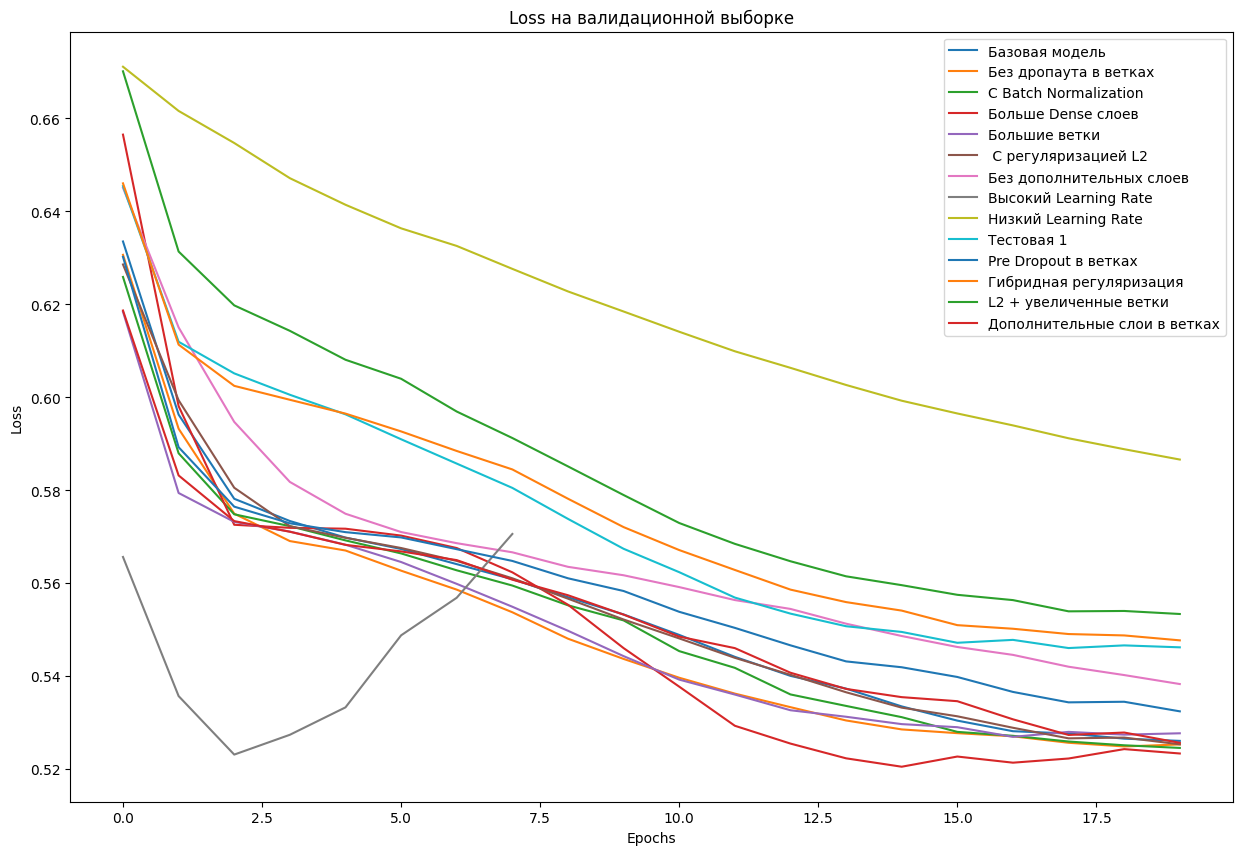

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 10))
for hist in histories:
    plt.plot(hist['history']['val_loss'], label=hist['name'])

plt.title('Loss на валидационной выборке')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Тест 2

### Увеличиваем размер датасета

In [1]:
from pathlib import Path
from vk_mod.data import load_dataset


SAMPLE_LIMIT:int = 10000
datasets = [
    Path('../data/preprocessed/image_only.csv'),
    Path('../data/preprocessed/text_only.csv'),
    Path('../data/preprocessed/text-and-image.csv'),
]
images_dir = Path("..data/images")

df = load_dataset(datasets, sample_limit=SAMPLE_LIMIT)

c:\Users\ShapeCat\source\repos\ToxicPostDetection\.venv\lib\site-packages\tensorflow_hub\__init__.py:61: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import parse_version


In [2]:
from sklearn.model_selection import train_test_split
from vk_mod.const import SEED


train_df, val_df = train_test_split(df, test_size=0.2, random_state=SEED)
train_df, test_df = train_test_split(df, test_size=0.2, random_state=SEED)

In [3]:
from vk_mod.preprocessing import TextPreprocessor, ImagePreprocessor
from vk_mod.data import DatasetGenerator

text_preprocessor = TextPreprocessor()
image_preprocessor = ImagePreprocessor(images_dir, image_model='mobilenet')
train_ds = DatasetGenerator(train_df, text_preprocessor, image_preprocessor).create_dataset()
val_ds = DatasetGenerator(val_df, text_preprocessor, image_preprocessor).create_dataset()
test_ds = DatasetGenerator(test_df, text_preprocessor, image_preprocessor,).create_dataset()

### Определяем конфигурации

In [4]:
configurations2 = [
    {
        "test_name": "Тестовая 2",
        "configuration": {
            "text_branch_dense_units": 192,
            "image_branch_dense_units": 192,
            "main_classifier_dense_layers": 3,
            "main_classifier_dense0_units": 256,
            "main_classifier_dense1_units": 128,
            "main_classifier_dense2_units": 64,
            "main_classifier_dropout0": 0.4,
            "main_classifier_dropout1": 0.3,
            "main_classifier_dropout2": 0.2,
            "main_classifier_l2_reg": 0.0003,
            "learning_rate": 1e-4,
            "text_branch_dropout_rate": 0.2,
            "image_branch_dropout_rate": 0.2
        }
    },
    {
        "test_name": "Быстрая",
        "configuration": {
            "main_classifier_use_batchnorm": True,
            "learning_rate": 1e-3,
            "text_branch_dropout_position": "post",
            "image_branch_dropout_position": "post"
        }
    },
    {
        "test_name": "Базовая улучшенная",
        "configuration": {
            "main_classifier_dense0_units": 192,
            "main_classifier_l2_reg": 0.0002
        }
    },
]

### Обучаем и оцениваем конфигурации

In [5]:
from vk_mod.models.tuning import compare_configurations

metrics2, histories2 = compare_configurations(train_ds, val_ds, test_ds, configurations2, epochs=100)


            Обучение: Тестовая 2
            Настройки: {'text_branch_dense_units': 192, 'image_branch_dense_units': 192, 'main_classifier_dense_layers': 3, 'main_classifier_dense0_units': 256, 'main_classifier_dense1_units': 128, 'main_classifier_dense2_units': 64, 'main_classifier_dropout0': 0.4, 'main_classifier_dropout1': 0.3, 'main_classifier_dropout2': 0.2, 'main_classifier_l2_reg': 0.0003, 'learning_rate': 0.0001, 'text_branch_dropout_rate': 0.2, 'image_branch_dropout_rate': 0.2}
            
Epoch 1/100
250/250 [==============================] - 466s 2s/step - loss: 0.7885 - accuracy: 0.6682 - val_loss: 0.7187 - val_accuracy: 0.7305 - lr: 1.0000e-04
Epoch 2/100
250/250 [==============================] - 439s 2s/step - loss: 0.7037 - accuracy: 0.7380 - val_loss: 0.6792 - val_accuracy: 0.7310 - lr: 1.0000e-04
Epoch 3/100
250/250 [==============================] - 440s 2s/step - loss: 0.6632 - accuracy: 0.7492 - val_loss: 0.6438 - val_accuracy: 0.7505 - lr: 1.0000e-04
Epoch 4/100

### Таблица результатов

In [6]:
import pandas as pd

results_df2 = pd.DataFrame(metrics2).sort_values(by="Loss", ascending=False)
results_df2

,Модель,Accuracy,Loss,Epochs
0,Тестовая 2,0.7645,0.593451,17
2,Базовая улучшенная,0.7650,0.527042,23
1,Быстрая,0.7695,0.508186,9


### График историй обучения

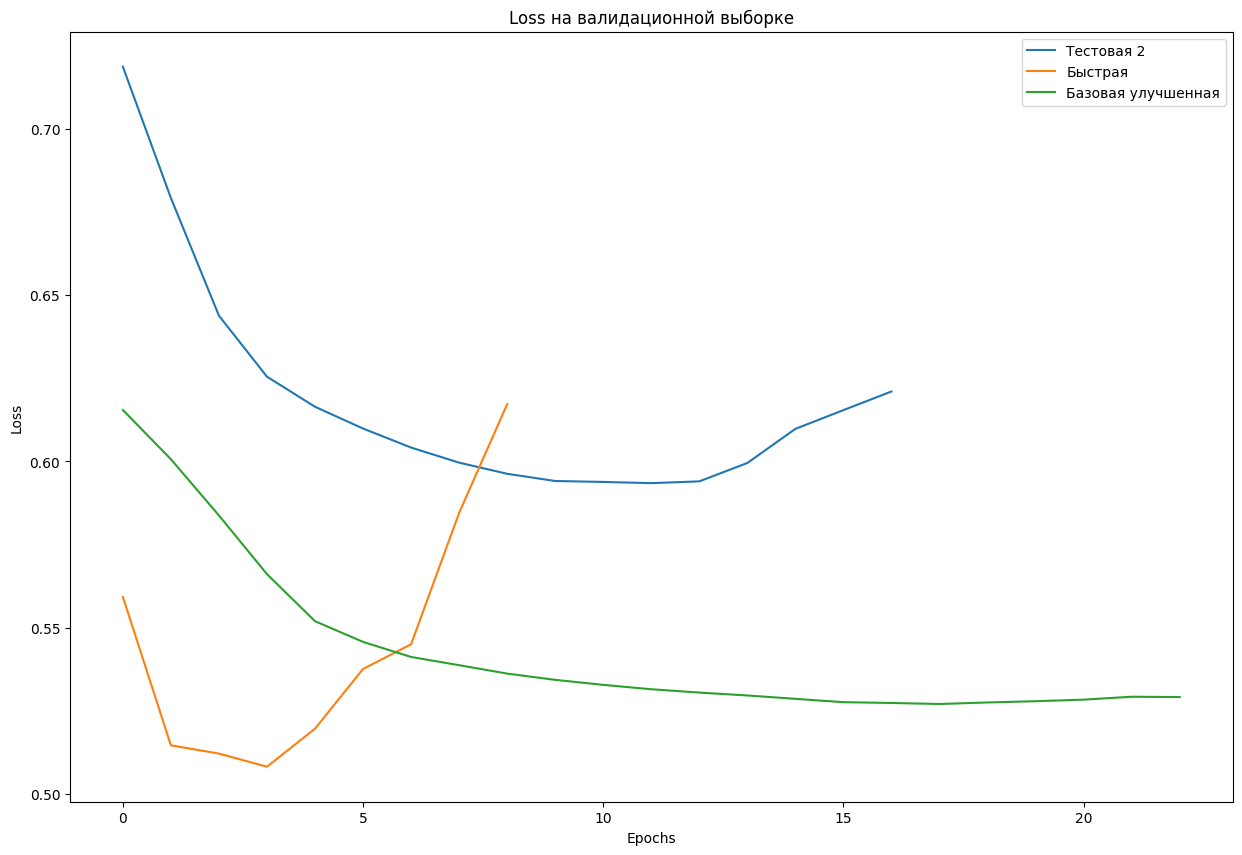

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 10))
for hist in histories2:
    plt.plot(hist['history']['val_loss'], label=hist['name'])

plt.title('Loss на валидационной выборке')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Тест 3: Быстрые большие ветки

### Орпделяем конфигурации

In [ ]:
configurations3 = [
    {
        "test_name": "Быстрая + больше слоев + pre dense в ветках",
        "configuration": {
            "main_classifier_use_batchnorm": True,
            "learning_rate": 1e-3,
            "text_branch_dense_units": 192,
            "image_branch_dense_units": 192,
            "main_classifier_dense_layers": 2,
            "main_classifier_dense0_units": 192,
            "main_classifier_dense1_units": 64, 
            "main_classifier_dropout0": 0.4,
            "main_classifier_dropout1": 0.2,
            "main_classifier_l2_reg": 0.0001,
            "text_branch_dropout_rate": 0.2,
            "image_branch_dropout_rate": 0.2,
            "text_branch_dropout_position": "pre",
            "image_branch_dropout_position": "pre"
        }
    },
    {
        "test_name": "Быстрая + больше слоев + post dense в ветках",
        "configuration": {
            "main_classifier_use_batchnorm": True,
            "learning_rate": 1e-3,
            "text_branch_dense_units": 192,
            "image_branch_dense_units": 192,
            "main_classifier_dense_layers": 2,
            "main_classifier_dense0_units": 192,
            "main_classifier_dense1_units": 64, 
            "main_classifier_dropout0": 0.4,
            "main_classifier_dropout1": 0.2,
            "main_classifier_l2_reg": 0.0001,
            "text_branch_dropout_rate": 0.2,
            "image_branch_dropout_rate": 0.2,
        }
    }
]

### Обычаем и оцениваем конфигурации

In [11]:
from vk_mod.models.tuning import compare_configurations

metrics3, histories3 = compare_configurations(train_ds, val_ds, test_ds, configurations3, epochs=100)


            Обучение: Быстрая + больше слоев + pre dense в ветках
            Настройки: {'main_classifier_use_batchnorm': True, 'learning_rate': 0.001, 'text_branch_dense_units': 192, 'image_branch_dense_units': 192, 'main_classifier_dense_layers': 2, 'main_classifier_dense0_units': 192, 'main_classifier_dense1_units': 64, 'main_classifier_dropout0': 0.4, 'main_classifier_dropout1': 0.2, 'main_classifier_l2_reg': 0.0001, 'text_branch_dropout_rate': 0.2, 'image_branch_dropout_rate': 0.2, 'text_branch_dropout_position': 'pre', 'image_branch_dropout_position': 'pre'}
            
Epoch 1/100
250/250 [==============================] - 486s 2s/step - loss: 0.6677 - accuracy: 0.6978 - val_loss: 0.6308 - val_accuracy: 0.7585 - lr: 0.0010
Epoch 2/100
250/250 [==============================] - 468s 2s/step - loss: 0.5801 - accuracy: 0.7468 - val_loss: 0.5450 - val_accuracy: 0.7635 - lr: 0.0010
Epoch 3/100
250/250 [==============================] - 501s 2s/step - loss: 0.5548 - accuracy: 0.761

### Таблица результатов

In [13]:
import pandas as pd

results_df3 = pd.DataFrame(metrics3).sort_values(by="Loss", ascending=False)
results_df3

,Модель,Accuracy,Loss,Epochs
1,Быстрая + больше слоев + post dense в ветках,0.7725,0.533346,9
0,Быстрая + больше слоев + pre dense в ветках,0.7670,0.530831,10


### График историй обучания

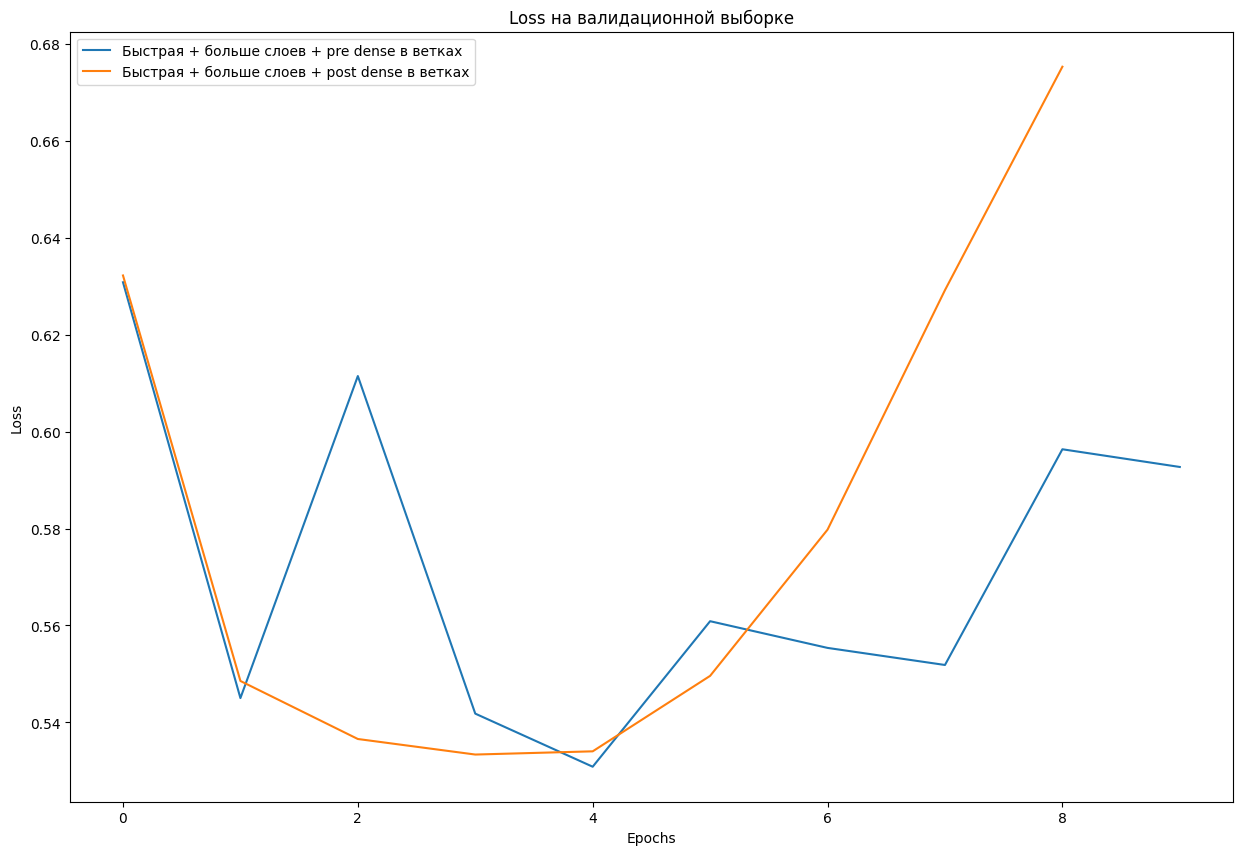

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 10))
for hist in histories3:
    plt.plot(hist['history']['val_loss'], label=hist['name'])

plt.title('Loss на валидационной выборке')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Тест4

### Орпделяем конфигурации

In [33]:
configurations4 = [
    {
        "test_name": "Быстрая + Pre dropout в ветках + 2 слоя в основном",
        "configuration": {
            "main_classifier_use_batchnorm": True,
            "learning_rate": 1e-3,
            "text_branch_dense_units": 192,
            "image_branch_dense_units": 192,
            "main_classifier_dense_layers": 2,
            "main_classifier_dense0_units": 192,
            "main_classifier_dense1_units": 64, 
            "main_classifier_dropout0": 0.3,
            "text_branch_dropout_position": "pre",
            "image_branch_dropout_position": "pre",
        }
    }
]

### Обучаем и оцениваем конфигруации

In [34]:
from vk_mod.models.tuning import compare_configurations

metrics4, histories4 = compare_configurations(train_ds, val_ds, test_ds, configurations4, epochs=100)


            Обучение: Быстрая + Pre dropout в ветках + 2 слоя в основном
            Настройки: {'main_classifier_use_batchnorm': True, 'learning_rate': 0.001, 'text_branch_dense_units': 192, 'image_branch_dense_units': 192, 'main_classifier_dense_layers': 2, 'main_classifier_dense0_units': 192, 'main_classifier_dense1_units': 64, 'main_classifier_dropout0': 0.3, 'text_branch_dropout_position': 'pre', 'image_branch_dropout_position': 'pre'}
            
Epoch 1/100
250/250 [==============================] - 604s 2s/step - loss: 0.6850 - accuracy: 0.6833 - val_loss: 0.6244 - val_accuracy: 0.5340 - lr: 0.0010
Epoch 2/100
250/250 [==============================] - 596s 2s/step - loss: 0.5804 - accuracy: 0.7290 - val_loss: 0.5339 - val_accuracy: 0.7540 - lr: 0.0010
Epoch 3/100
250/250 [==============================] - 536s 2s/step - loss: 0.5381 - accuracy: 0.7561 - val_loss: 0.5245 - val_accuracy: 0.7630 - lr: 0.0010
Epoch 4/100
250/250 [==============================] - 556s 2s/step - 

### Таблица результатов

In [35]:
import pandas as pd

results_df4 = pd.DataFrame(metrics4).sort_values(by="Loss", ascending=False)
results_df4

,Модель,Accuracy,Loss,Epochs
0,Быстрая + Pre dropout в ветках + 2 слоя в осно...,0.7645,0.507106,10


### График историй обучения

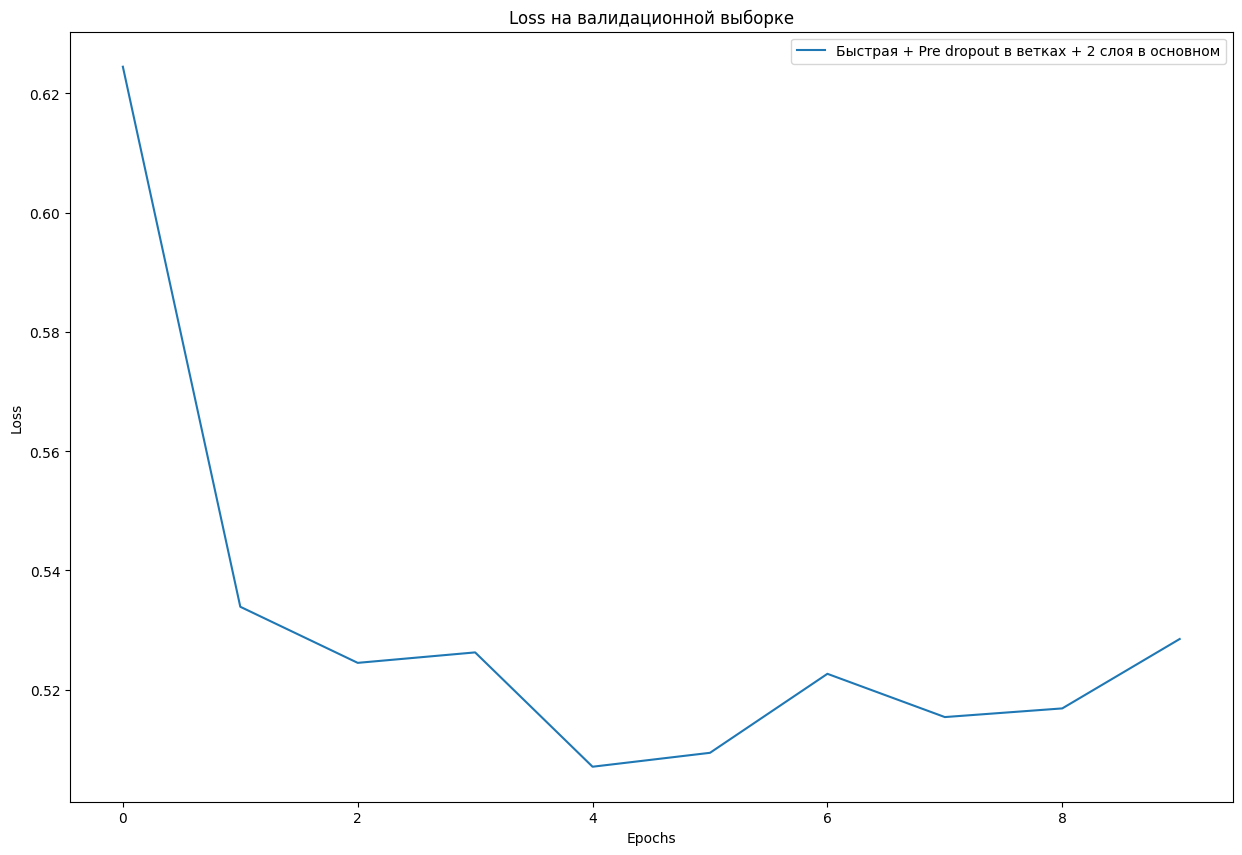

In [36]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 10))
for hist in histories4:
    plt.plot(hist['history']['val_loss'], label=hist['name'])

plt.title('Loss на валидационной выборке')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()